In [1]:
from pandas import DataFrame
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from collections import defaultdict,Counter

root_path= "D:\OneDrive\OneDrive - The University of Melbourne\COMP90042Project\{}"
root_list_path= root_path.format("project-data\{}")
covid_pickle_label =root_list_path.format("covid_df_with_label.pkl")
covid_pickle= root_list_path.format("covid_df.pkl")

# covid_pickle= '../project-data/covid_df.pkl'
# covid_pickle_label= '../project-data/covid_df_with_label.pkl'

covid_df_label = pd.read_pickle(covid_pickle_label)
covid_df = pd.read_pickle(covid_pickle)
covid_df['predict_label']= covid_df_label['predict_label']

covid_df["created_at"] = pd.to_datetime(covid_df["created_at"])
# covid_df = covid_df.sort_values(by="created_at")  # order source tweets chronologically
covid_df['month'] = pd.DatetimeIndex(covid_df['created_at']).month  #add a column for month
covid_df

,tweet_id,user_id,followers_count,friends_count,listed_count,favourites_count,verified,hastags,text,created_at,in_reply_to_status_id,retweet_count,favorite_count,reply_avg_sent,reply_sent_trend,reply_text,predict_label,month
0,1272262651100434433,1011312260805996547,44969,16,271,454,False,"[{'text': 'Tenet', 'indices': [82, 88]}]","according to the new york times, warner bros. ...",2020-06-14 20:20:28+00:00,None,26,261,0.000000,0,,0,6
1,1287153210990395392,44513878,296750,56399,5505,3263,True,[],hurricane hanna has made landfall in texas.\n\...,2020-07-25 22:30:14+00:00,None,480,579,-0.250000,0,guess what the cause of death is from a hurri...,0,7
2,1266555444283179008,1917731,4351141,296,29057,10,True,[],monkeys on the loose in india with stolen coro...,2020-05-30 02:22:04+00:00,None,72,165,0.000000,0,,1,5
3,1274338812173393920,234186830,203920,1371,2061,7352,True,[],"“if trump felt comfortable having it here, the...",2020-06-20 13:50:23+00:00,None,786,1951,-0.123505,0,these trump fans have a right to attend this ...,0,6
4,1278703879828303877,16374678,1177273,487,6314,4273,True,"[{'text': 'COVID19', 'indices': [104, 112]}]",disturbing: alabama officials say some student...,2020-07-02 14:55:36+00:00,None,256,473,0.000000,0,,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,1245381089834786816,7587032,7749909,23,29950,1,True,"[{'text': 'COVID19', 'indices': [68, 76]}]",breaking: a doctor who came out of retirement ...,2020-04-01 16:02:44+00:00,None,1636,4069,0.364950,0,"dr. alfa saadu was a nigerian doctor,that sac...",0,4
625,1269038270064844801,36686040,1683979,692,7445,1332,True,[],is there one brave member of trump’s cabinet w...,2020-06-05 22:47:55+00:00,None,32332,151831,-0.261268,0,"unfortunately, there's none.\n#covid19 is no...",0,6
626,1244657232849108992,878247600096509952,3111026,34,7203,20334,True,[],"in january, california was recording about 580...",2020-03-30 16:06:23+00:00,None,1876,6311,0.063583,0,"well, the spirit of those statements are inco...",0,3
627,1265244843988652035,368240745,601172,2391,1459,53421,True,[],right...anyone checking on what other bad stuf...,2020-05-26 11:34:12+00:00,None,3307,26791,-0.134314,0,"well they're still planning to #selloff #nhs,...",0,5


In [2]:
#Task 1. popular hashtags of COVID-19 rumours and non-rumours
rumor_hashtags,nonrumor_hashtags=defaultdict(),defaultdict()

def get_hashtag_count(df,rumor_tags,nonrumor_tags):
    for i in df.loc[df['hastags']!="[]"].index: 
        hashtags = df.at[i,'hastags']
        hashtag_list=[]

        for hashtag in hashtags:
            if hashtag['text'].lower() not in hashtag_list: #avoid repeated hashtags diff by upper/lower case
                hashtag_list.append(hashtag['text'].lower())
        if df.at[i,'predict_label']==0: #non-rumor
            for tag in hashtag_list:
                if tag not in nonrumor_tags.keys():
                    nonrumor_tags[tag]=1
                else:
                    nonrumor_tags[tag]+=1
        elif df.at[i,'predict_label']==1: #rumor
            for tag in hashtag_list:
                if tag not in rumor_tags.keys():
                    rumor_tags[tag]=1
                else:
                    rumor_tags[tag]+=1  
                        
                        
get_hashtag_count(covid_df,rumor_hashtags,nonrumor_hashtags)       
rumor_hashtags=dict(sorted(rumor_hashtags.items(),  
                             key=lambda item: item[1],  #top 5 most popular
                             reverse=True)[:10])  
nonrumor_hashtags=dict(sorted(nonrumor_hashtags.items(),
                             key=lambda item: item[1],
                             reverse=True)[:10])  

print(rumor_hashtags)  #TODO: mostly not covid-related
print(nonrumor_hashtags)

{'coronavirus': 2, 'covid19': 2, 'trumpmeltdown': 1, 'trumppressconference': 1, 'golf': 1, 'trump': 1, 'deadder': 1}
{'covid19': 55, 'coronavirus': 25, 'breaking': 4, 'lockdown': 2, 'trump': 2, 'safehands': 2, 'china': 2, 'tenet': 1, 'udmchiefwhip': 1, 'houston': 1}


In [3]:
# Task 2: rumor source tweet convey diff sentiment than non-rumor source tweet?
# what about replies?
import statistics
sid = SentimentIntensityAnalyzer()
covid_df['source_sent']= covid_df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

rumor_source_sent,nonrumor_source_sent,rumor_reply_sent,nonrumor_reply_sent=[],[],[],[]
# get mean,median,sd of sentiment

def get_stats(alist): 
    mean= round(statistics.mean(alist),2)
    sd= round(statistics.stdev(alist),2)
    median= round(statistics.median(alist),2)
    return {'mean':mean,'sd':sd,'median':median}


def get_sent_stats(*dfs): # *args
    rumor_source_sent,rumor_reply_sent,nonrumor_source_sent,nonrumor_reply_sent =[],[],[],[]
    stats_dict={}
    for df in dfs:
        rumor_source_sent += [x for x in df.loc[df['predict_label'] == 1]['source_sent']]
        rumor_reply_sent +=  [x for x in df.loc[df['predict_label'] == 1]['reply_avg_sent']]
        nonrumor_source_sent += [x for x in df.loc[df['predict_label'] == 0]['source_sent']]
        nonrumor_reply_sent += [x for x in df.loc[df['predict_label'] == 0]['reply_avg_sent']]
    
    stats_dict['rumor_source_sent']=get_stats(rumor_source_sent)
    stats_dict['rumor_reply_sent']=get_stats(rumor_reply_sent)
    stats_dict['nonrumor_source_sent']=get_stats(nonrumor_source_sent)
    stats_dict['nonrumor_reply_sent']=get_stats(nonrumor_reply_sent)
    return stats_dict


sent_stats=get_sent_stats(covid_df)
print(sent_stats)

{'rumor_source_sent': {'mean': -0.06, 'sd': 0.45, 'median': 0.0}, 'rumor_reply_sent': {'mean': -0.07, 'sd': 0.24, 'median': 0.0}, 'nonrumor_source_sent': {'mean': 0.0, 'sd': 0.4, 'median': 0.0}, 'nonrumor_reply_sent': {'mean': -0.01, 'sd': 0.25, 'median': 0.0}}


<AxesSubplot:>

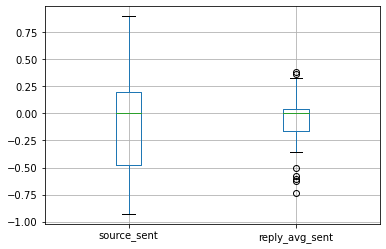

In [21]:
# box plots
covid_df.loc[covid_df['predict_label'] == 1].boxplot(column=['source_sent','reply_avg_sent'])

<AxesSubplot:>

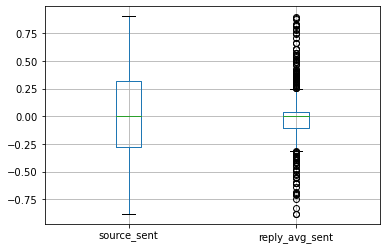

In [18]:
covid_df.loc[covid_df['predict_label'] == 0].boxplot(column=['source_sent','reply_avg_sent'])

In [4]:
# Task 3:characteristics of rumour-creating users, and are they different to normal users?
# For rumor-creating VS normal users:
# get mean,median,SD of popularity indicators: followers_count,  friends_count, listed_count(# people added you to a list)
# Verified status

# from sklearn.preprocessing import MinMaxScaler
# mm_scale = MinMaxScaler()
# covid_df['followers_count'] = mm_scale.fit_transform(covid_df[['followers_count']])
# covid_df['friends_count'] = mm_scale.fit_transform(covid_df[['friends_count']])
# covid_df['listed_count'] = mm_scale.fit_transform(covid_df[['listed_count']])

def get_user_info(df,user_info_dict,user_occ, infoA,infoB,infoC,infoD):
    for i in df.index:
        user_id=df.at[i,'user_id']
        if user_id not in user_info_dict.keys(): 
            user_info_dict[user_id]={infoA:df.at[i,infoA],infoB:df.at[i,infoB],infoC:df.at[i,infoC],infoD:df.at[i,infoD]}
            user_occ[user_id]=1
            
        else:  # record user occurrence in rumor/unrumor tweets
            user_occ[user_id]+=1
            

def get_rumor_normal_users(*dfs):    
    stats= {}
    rumor_user_info, normal_user_info= {},{} # {userid: {info}}
    rumor_user_occ, normal_user_occ= {},{}   # {userid: occurrence in tweets}
    for df in dfs:
        get_user_info(df.loc[df['predict_label'] == 1],  # get users from rumor tweets
                      rumor_user_info,
                      rumor_user_occ,
                      "followers_count","friends_count","listed_count","verified")
        get_user_info(df.loc[df['predict_label'] == 0], # get users from nonrumor tweets
                      normal_user_info,
                      normal_user_occ,
                      "followers_count","friends_count","listed_count","verified")
        
        for user in list(rumor_user_info.keys()): 
                if user in list(normal_user_info.keys()):  # if user also sent non-rumor tweet(s)
                    if rumor_user_occ[user] < normal_user_occ[user]: #if the user has #rumor tweets < #normal tweets
                        del rumor_user_info[user]                       # treat as normal user
                    else:
                        del normal_user_info[user]
                        
    
    rumor_followers=[rumor_user_info[x]['followers_count'] for x in rumor_user_info.keys()]
    normal_followers=[normal_user_info[x]['followers_count'] for x in normal_user_info.keys()]
    
    rumor_friends=[rumor_user_info[x]['friends_count'] for x in rumor_user_info.keys()]
    normal_friends=[normal_user_info[x]['friends_count'] for x in normal_user_info.keys()]
    
    rumor_list=[rumor_user_info[x]['listed_count'] for x in rumor_user_info.keys()]
    normal_list=[normal_user_info[x]['listed_count'] for x in normal_user_info.keys()]
    
    rumor_verified=[rumor_user_info[x]['verified'] for x in rumor_user_info.keys()]
    normal_verified=[normal_user_info[x]['verified'] for x in normal_user_info.keys()]

    stats["rumor_followers"]= get_stats(rumor_followers)
    stats["normal_followers"]= get_stats(normal_followers)
    stats["rumor_friends"]= get_stats(rumor_friends)
    stats["normal_friends"]= get_stats(normal_friends)
    stats["rumor_list"]= get_stats(rumor_list)
    stats["normal_list"]= get_stats(normal_list)
    stats["rumor_%verified"]= {key: round(Counter(rumor_verified)[key]/len(rumor_verified),2) 
                               for key in Counter(rumor_verified).keys()}
    stats["normal_%verified"]= {key: round(Counter(normal_verified)[key]/len(normal_verified),2) 
                                for key in Counter(normal_verified).keys()}  

    return stats

user_stats=get_rumor_normal_users(covid_df)
print(user_stats)

{'rumor_followers': {'mean': 1177563, 'sd': 2357676.0, 'median': 221267.0}, 'normal_followers': {'mean': 3154650, 'sd': 9232295.62, 'median': 388498}, 'rumor_friends': {'mean': 5540, 'sd': 11887.57, 'median': 1745.0}, 'normal_friends': {'mean': 8384, 'sd': 32034.7, 'median': 1184}, 'rumor_list': {'mean': 6863, 'sd': 10981.09, 'median': 2699.0}, 'normal_list': {'mean': 9776, 'sd': 24693.03, 'median': 2011}, 'rumor_%verified': {False: 0.23, True: 0.78}, 'normal_%verified': {False: 0.26, True: 0.74}}


In [5]:
# Task 4: topics of COVID-19 rumours, and how do they differ from the non-rumours? [topic modelling]
# TFIDF over rumor tweets of covid data, then feed into LDA 

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm",disable = ['ner','parser']) 
stopwords = stopwords.words('english')
corpus=[]

def preprocess(text):
    processed_text= []
    doc=nlp(text)
    lemmatized_tokens= [token.lemma_ for token in doc]  #lemmatize
    for token in lemmatized_tokens:
        if token not in stopwords:
            if (any(c.isalpha() for c in token)): #remove words not containing any alphabets  #is it necessary?
                processed_text.append(token)
    return " ".join(processed_text)


# constants
TOP_FEATURE_COUNT= 500 
TOPIC_COUNT= 3
TOP_WORD_COUNT = 15


# tfidf
tfidf_vec = TfidfVectorizer(max_features=TOP_FEATURE_COUNT,
                            preprocessor = preprocess,  # only consider the top 500 features ordered by TF
                            max_df=0.95)                 #filter out common words

# lda
lda = LatentDirichletAllocation(n_components=TOPIC_COUNT,  # number of topics
                                random_state=0)


def print_top_words(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_): #components_: 2d array of shape n topics * n features
        print('\nTopic No.%d:' % int(topic_id + 1)) 
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2))
              +' | ' for i in topic.argsort()[:-n_top_words - 1:-1]]))

        
# corpus
total_corpus= covid_df['text'].tolist()
rumor_corpus= covid_df.loc[covid_df['predict_label'] == 1]['text'].tolist()
nonrumor_corpus= covid_df.loc[covid_df['predict_label'] == 0]['text'].tolist()

# for both
tfidf_vec.fit(total_corpus)
feature_names = tfidf_vec.get_feature_names()
# print(len(tfidf_vec.get_feature_names()))  #500 features
# print(topic_probability_scores.shape) # (2103, 5)

In [6]:
tfidf_rumor = tfidf_vec.transform(rumor_corpus)
rumor_topic_probability_scores= lda.fit_transform(tfidf_rumor)                     
print_top_words(lda, feature_names, TOP_WORD_COUNT)


Topic No.1:
trump 1.81 | american 1.73 | response 1.6 | say 1.44 | see 1.35 | joe 1.34 | gop 1.33 | biden 1.26 | coronavirus 1.24 | people 1.22 | covid 1.19 | right 1.17 | back 1.13 | close 1.08 | president 1.02 | 

Topic No.2:
trump 3.57 | coronavirus 2.25 | obama 1.61 | covid19 1.34 | mcconnell 1.28 | april 1.23 | fail 1.21 | anti 1.2 | death 1.19 | think 1.13 | come 1.12 | leader 1.12 | million 1.09 | may 1.08 | medium 1.07 | 

Topic No.3:
hand 1.26 | flu 1.16 | want 1.07 | steal 1.03 | actually 1.01 | india 1.0 | trump 0.94 | election 0.93 | become 0.91 | th 0.89 | thing 0.89 | protester 0.84 | week 0.84 | reopen 0.82 | coronavirus 0.82 | 


In [7]:
# for non-rumor data
tfidf_nonrumor = tfidf_vec.transform(nonrumor_corpus)
nonrumor_topic_probability_scores= lda.fit_transform(tfidf_nonrumor)
print_top_words(lda, feature_names, TOP_WORD_COUNT)


Topic No.1:
covid 20.84 | 19 20.31 | coronavirus 16.75 | say 10.29 | test 9.6 | positive 9.32 | people 8.76 | case 6.9 | mask 6.77 | president 6.33 | die 6.31 | new 6.12 | make 5.95 | death 5.93 | spread 5.72 | 

Topic No.2:
trump 9.28 | covid19 8.84 | coronavirus 8.51 | test 6.63 | home 5.95 | time 5.82 | state 5.11 | work 4.62 | know 4.57 | back 4.49 | social 4.33 | right 4.29 | donald 4.22 | america 4.21 | high 3.88 | 

Topic No.3:
coronavirus 10.91 | new 7.37 | report 6.98 | covid19 6.34 | case 5.6 | uk 5.11 | death 4.8 | country 4.74 | today 4.56 | show 4.39 | lockdown 4.37 | video 4.34 | plan 4.19 | break 3.95 | ve 3.89 | 


In [8]:
# Task 5: How COVID-19 rumour topics or trends evolve over time?
#  for each rumor tweet, probability distribution over all 3 topics
#  choose the topic corresponding to largest prob as tweet topic
#  analyse the most popular topic by month

import numpy as np

rumor_df= covid_df.loc[covid_df['predict_label'] == 1].copy()  # get a deep copy of rumor dataframe
correct_index= [num for num in range(0,len(rumor_df))]
rumor_df=rumor_df.set_index(pd.Index(correct_index))  
rumor_df

topic_list=[]  
for i in range(len(rumor_topic_probability_scores)):
    prob_dis= rumor_topic_probability_scores[i]
    topic_id= np.where(prob_dis== max(prob_dis))[0][0] + 1   # topic for each tweet has max probability over distribution
    topic_list.append(topic_id) 
    
    
# generate a list of topics for each month
month_topics=data = defaultdict(list)
for i in rumor_df.index:
    topic= topic_list[i]
    month_topics[rumor_df.at[i,'month']].append(topic)
    
for i in month_topics.keys():
    month_topics[i]= Counter(month_topics[i])
    month_topics[i]= dict(sorted(month_topics[i].items(),  #get top 10 most popular hashtags  
                             key=lambda item: item[1],
                             reverse=True))
    
month_topics

defaultdict(list,
            {5: {1: 6, 2: 6, 3: 1},
             6: {3: 2, 2: 2, 1: 1},
             4: {1: 9, 2: 6, 3: 3},
             3: {2: 3, 1: 1},
             7: {2: 3, 3: 3, 1: 2},
             2: {3: 1, 1: 1}})